In [86]:
from torchvision import datasets, transforms

# Transformacja do tensora
transform = transforms.ToTensor()

# Załaduj dane treningowe MNIST
train_data = datasets.MNIST(root=".", train=True, download=True, transform=transform)

test_data = datasets.MNIST(root=".", train=False, download=True, transform=transforms.ToTensor())


In [87]:
from torch.utils.data import DataLoader

# Ustawiamy rozmiar batcha (np. 64 obrazki na raz)
batch_size = 64

# Tworzymy DataLoader dla danych treningowych i testowych
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [88]:
from torch import nn
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Flatten()
        self.fc2 = nn.Linear(784,128)
        self.act1 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.out = nn.Linear(64, 32)

    def forward(self, x):
        x = self.fc1(x)  
        x = self.fc2(x)   
        x = self.act1(x) 
        x = self.fc3(x)            
        x = self.act2(x)     
        x = self.out(x)
        return x
    
class Autodecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32,64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64,128)
        self.act2 = nn.ReLU()
        self.out = nn.Linear(128,784)
        self.out_act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.out(x)
        x = self.out_act(x)
        return x

class FullAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Autoencoder()
        self.fc2 = Autodecoder()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)   
        return x

class LatentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Linear(32,10)
    
    def forward(self,x):
        return self.out(x)

In [89]:
import torch


model = FullAutoencoder()
loss_fn_mse = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters())

In [90]:
for epoch in range(10):
    for batch in train_loader:
        images, _ = batch  # etykiety nas nie interesują!
        outputs = model(images)
        loss = loss_fn_mse(outputs, images.view(images.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch}, loss {loss}")

epoch 0, loss 0.026262857019901276
epoch 1, loss 0.02345929853618145
epoch 2, loss 0.018598923459649086
epoch 3, loss 0.017918307334184647
epoch 4, loss 0.014904486946761608
epoch 5, loss 0.011500105261802673
epoch 6, loss 0.011985702440142632
epoch 7, loss 0.011665407568216324
epoch 8, loss 0.011267654597759247
epoch 9, loss 0.00925908237695694


torch.Size([64, 32])


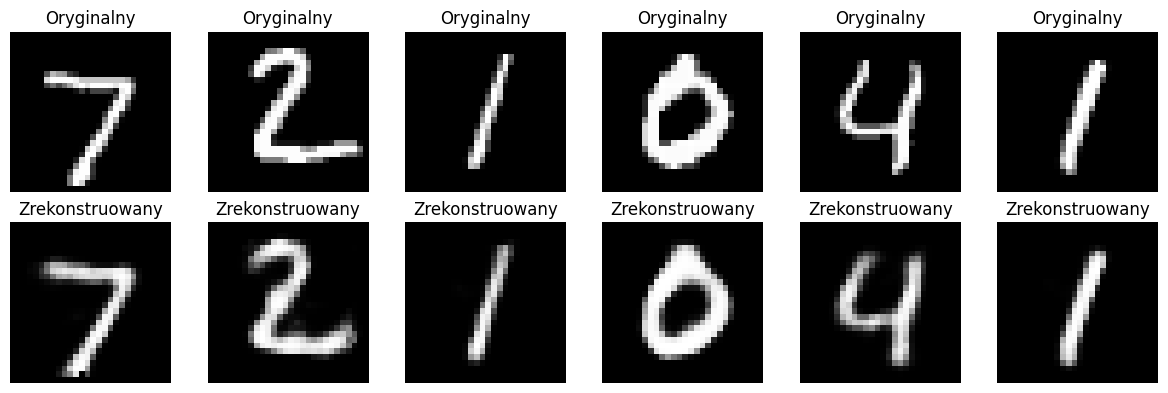

In [91]:

images, _ = next(iter(test_loader))

model.eval()  # wyłącza dropout/batchnorm, jeśli byłyby
with torch.no_grad():
    reconstructed = model(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)

with torch.no_grad():
    latent_vectors = model.fc1(images)  # <- fc1 = encoder
    print(latent_vectors.shape)

import matplotlib.pyplot as plt

n = 6  # liczba obrazków do pokazania
plt.figure(figsize=(12, 4))

for i in range(n):
    # Oryginał
    plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze().numpy(), cmap="gray")
    plt.title("Oryginalny")
    plt.axis("off")
    
    # Rekonstrukcja
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze().numpy(), cmap="gray")
    plt.title("Zrekonstruowany")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [92]:
letant_classifier = LatentClassifier()
loss_fn_ce = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(letant_classifier.parameters())

In [93]:
X_latent = []
Y_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        latents = model.fc1(images)
        X_latent.append(latents)
        Y_labels.append(labels)

X_latent = torch.cat(X_latent)
Y_labels = torch.cat(Y_labels)
letant_classifier_accuracy = 0.0
for epoch in range(100):
    total_loss = 0
    correct = 0
    total = 0
    
    # Możesz pociąć dane na mniejsze batch'e
    for i in range(0, len(X_latent), 64):
        x_batch = X_latent[i:i+64]
        y_batch = Y_labels[i:i+64]

        output = letant_classifier(x_batch)  # logity
        loss = loss_fn_ce(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    accuracy = correct / total
    avg_loss = total_loss / (len(X_latent) // 64)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    letant_classifier_accuracy = accuracy
    

Epoch 0, Loss: 0.8232, Accuracy: 0.7569
Epoch 1, Loss: 0.4066, Accuracy: 0.8772
Epoch 2, Loss: 0.3763, Accuracy: 0.8843
Epoch 3, Loss: 0.3652, Accuracy: 0.8869
Epoch 4, Loss: 0.3595, Accuracy: 0.8887
Epoch 5, Loss: 0.3560, Accuracy: 0.8900
Epoch 6, Loss: 0.3535, Accuracy: 0.8907
Epoch 7, Loss: 0.3517, Accuracy: 0.8913
Epoch 8, Loss: 0.3502, Accuracy: 0.8916
Epoch 9, Loss: 0.3489, Accuracy: 0.8919
Epoch 10, Loss: 0.3479, Accuracy: 0.8920
Epoch 11, Loss: 0.3469, Accuracy: 0.8926
Epoch 12, Loss: 0.3460, Accuracy: 0.8930
Epoch 13, Loss: 0.3452, Accuracy: 0.8935
Epoch 14, Loss: 0.3445, Accuracy: 0.8936
Epoch 15, Loss: 0.3437, Accuracy: 0.8938
Epoch 16, Loss: 0.3431, Accuracy: 0.8940
Epoch 17, Loss: 0.3425, Accuracy: 0.8942
Epoch 18, Loss: 0.3419, Accuracy: 0.8944
Epoch 19, Loss: 0.3413, Accuracy: 0.8946
Epoch 20, Loss: 0.3407, Accuracy: 0.8949
Epoch 21, Loss: 0.3402, Accuracy: 0.8949
Epoch 22, Loss: 0.3397, Accuracy: 0.8952
Epoch 23, Loss: 0.3392, Accuracy: 0.8954
Epoch 24, Loss: 0.3387, Ac

In [94]:
model.eval()  # ważne w przypadku Dropout/BatchNorm (nie masz ich, ale to dobra praktyka)
reconstruction_loss = 0.0
total_images = 0

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)  # [batch, 784]
        loss = loss_fn_mse(outputs, images.view(images.size(0), -1))  # MSE

        reconstruction_loss += loss.item() * images.size(0)  # suma strat
        total_images += images.size(0)

full_autoencoder_loss = reconstruction_loss / total_images
full_autoencoder_accuracy = 1.0 - full_autoencoder_loss
print(f"Full Autoencoder Test MSE: {full_autoencoder_accuracy:.6f}")

print(f"Latent Classifier Accuracy: {letant_classifier_accuracy:.4f}")

Full Autoencoder Test MSE: 0.990112
Latent Classifier Accuracy: 0.9006
